# Python for Calculus

### Importing libraries

In [1]:
import numpy as np
import pylab as pl
import os
from tempfile import TemporaryFile
from scipy import integrate

### Importing March data

Daily data from march 10 to april 20

In [3]:
data_infec = np.load('data/data_infec.npy')
data_infec1 = np.load('data/data_infec1.npy')
data_death = np.load('data/data_death.npy')
data_hosp = np.load('data/data_hosp.npy')

In [4]:
N_days1 = len(data_infec1)
N_days = len(data_infec)
data_cumu_death = np.zeros(N_days)
data_cumu_death[0] = data_death[0]
for i in range(1,N_days):
    data_cumu_death[i] = data_death[i] + data_cumu_death[i-1]

In [5]:
### parameters first paper
gamma_H = 1.0/5.0
gamma_A = 1.0/7.0
gamma = 1.0/7.0
p = 0.5
k = 1.0/5.0

In [6]:
### Set the dynamical system
def rhs(x,t,q):
    beta_I, eta, m, N = q
    m_I = 0.1*m
    beta_A = 2.0 * beta_I

    fx = np.zeros(7)
    fx[0] = -(beta_A*x[2]+beta_I*x[3])*x[0]/N   ### S dot
    fx[1] = (beta_A*x[2]+beta_I*x[3])*x[0]/N - k*x[1]  ### E dot
    fx[2] = (1-p)*k*x[1] -gamma_A*x[2] ### A dot
    fx[3] = p*k*x[1] - gamma*x[3] - eta*x[3] -m_I*x[3] ### I dot
    fx[4] = eta*x[3] - gamma_H*x[4] - m*x[4] ### H dot
    fx[5] = gamma_A * x[2] + gamma*x[3] + gamma_H*x[4] ### R dot
    fx[6] = m*x[4] + m_I*x[3]   ### D dot
    return fx

In [7]:
### Set initial conditions
A_0 = 20.0
H_0 = 0.0
R_0 = 0.0
D_0 = 0.0

Time2 = np.arange(0,N_days,1)

We solve numerically the ODEs system. q1 and q2 are the sets of parameters. Since we consider time before and after the first lockdown, q1 is the set for the initial contact rate, q2 is for the contact rate after the lockdown. Also, we define a numerical solution to predict the numerical solution in time (sol_betas_FT). 

In [8]:
def sol_betas(x0,q1,q2):
    Time0 = np.arange(0,N_days1,1)
    def soln(x0,Time,q):
        return integrate.odeint(rhs,x0,Time,args=(q,))
    my_soln0 = soln(x0,Time0,q1)
    Time1 = np.arange(N_days1-1,N_days,1)
    my_soln1 = soln(my_soln0[-1],Time1,q2)
    return my_soln0, my_soln1

def sol_betas_FT(x0,q1,q2,Final_Time):
    Time0 = np.arange(0,N_days1,1)
    def soln(x0,Time,q):
        return integrate.odeint(rhs,x0,Time,args=(q,))
    my_soln0 = soln(x0,Time0,q1)
    Time1 = np.arange(N_days1-1,Final_Time,1)
    my_soln1 = soln(my_soln0[-1],Time1,q2)
    return my_soln0, my_soln1

In [9]:
burnin = 7000
T = 40000

chain = np.load('data/cadena.npy')

Energy = chain[:,-1]


In [10]:
### Computing the MAP estimate
energy_MAP = min(Energy)
loc_MAP = np.where(Energy==energy_MAP)[0]
MAP = chain[loc_MAP[-1]]
MAP = MAP[:-1]

### Computing the posterior mean
Post_mean = np.ones(7)
Post_mean[0] = np.mean(chain[burnin:,0])
Post_mean[1] = np.mean(chain[burnin:,1])
Post_mean[2] = np.mean(chain[burnin:,2])
Post_mean[3] = np.mean(chain[burnin:,3])
Post_mean[4] = np.mean(chain[burnin:,4])
Post_mean[5] = np.mean(chain[burnin:,5])
Post_mean[6] = np.mean(chain[burnin:,6])


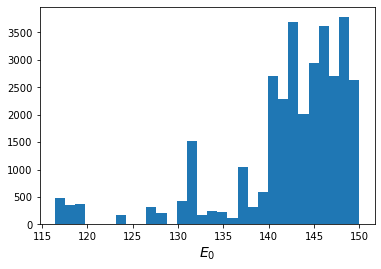

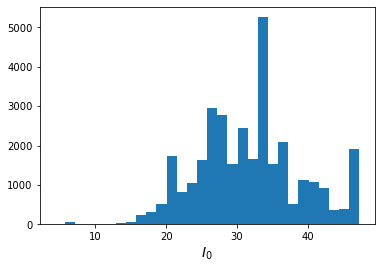

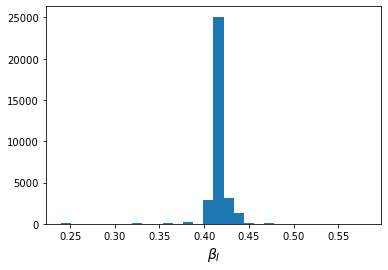

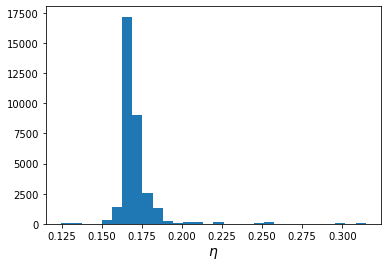

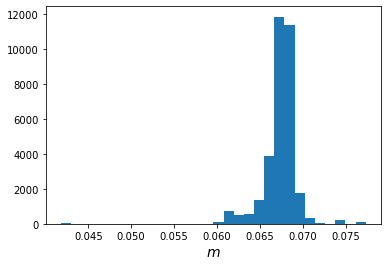

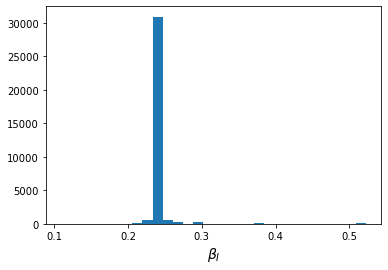

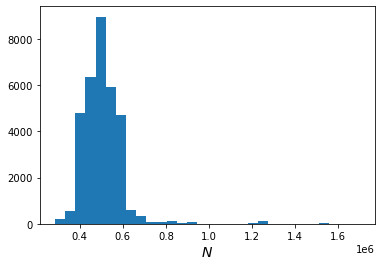

In [11]:
pl.figure()
pl.hist(chain[burnin:,0],bins=30)
pl.xlabel(r"$E_0$", fontsize=14)
pl.savefig('results/E_0.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,1],bins=30)
pl.xlabel(r"$I_0$", fontsize=14)
pl.savefig('results/I_0.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,2],bins=30)
pl.xlabel(r"$\beta_I$", fontsize=14)
pl.savefig('results/beta_I1.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,3],bins=30)
pl.xlabel(r"$\eta$", fontsize=14)
pl.savefig('results/eta.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,4],bins=30)
pl.xlabel(r"$m$", fontsize=14)
pl.savefig('results/m.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,5],bins=30)
pl.xlabel(r"$\beta_I$", fontsize=14)
pl.savefig('results/beta_I2.png')
pl.show()

pl.figure()
pl.hist(chain[burnin:,6],bins=30)
pl.xlabel(r"$N$", fontsize=14)
pl.savefig('results/S_0.png')
pl.show()


In [12]:
E_0, I_0, beta_I1, eta, m, beta_I2, S_0 = MAP
N = S_0 + E_0 + A_0 + I_0 + H_0 + R_0 + D_0
q1_MAP = np.array([beta_I1, eta, m, N])
q2_MAP = np.array([beta_I2, eta, m, N])

x0 = np.array([S_0, E_0, A_0, I_0, H_0, R_0, D_0])

my_soln1_MAP, my_soln2_MAP = sol_betas(x0,q1_MAP,q2_MAP)
exposed_day1_MAP = my_soln1_MAP[:,1]
exposed_day2_MAP = my_soln2_MAP[:,1][1:]
exposed_day_MAP = np.concatenate((exposed_day1_MAP, exposed_day2_MAP))
infected_day1_MAP = my_soln1_MAP[:,3]
infected_day2_MAP = my_soln2_MAP[:,3][1:]
infected_day_MAP = np.concatenate((infected_day1_MAP, infected_day2_MAP))
cumu_death1_MAP = my_soln1_MAP[:,6]
cumu_death2_MAP = my_soln2_MAP[:,6][1:]
cumu_death_MAP = np.concatenate((cumu_death1_MAP,cumu_death2_MAP))
incidence_cases_MAP = np.ones(len(exposed_day_MAP))
incidence_cases_MAP[0]=p*k*exposed_day_MAP[0]
hosp_cases_MAP = np.ones(len(infected_day_MAP))
hosp_cases_MAP[0]=eta*infected_day_MAP[0]
for i in np.arange(1,N_days,1):
    incidence_cases_MAP[i]=0.5*p*k*(exposed_day_MAP[i]+exposed_day_MAP[i-1])
    hosp_cases_MAP[i]= 0.5*eta*(infected_day_MAP[i]+infected_day_MAP[i-1])


E_0, I_0, beta_I1, eta, m, beta_I2, S_0 = Post_mean
N = S_0 + E_0 + A_0 + I_0 + H_0 + R_0 + D_0
q1_CM = np.array([beta_I1, eta, m, N])
q2_CM = np.array([beta_I2, eta, m, N])

x0 = np.array([S_0, E_0, A_0, I_0, H_0, R_0, D_0])

my_soln1_CM, my_soln2_CM = sol_betas(x0,q1_CM,q2_CM)
exposed_day1_CM = my_soln1_CM[:,1]
exposed_day2_CM = my_soln2_CM[:,1][1:]
exposed_day_CM = np.concatenate((exposed_day1_CM, exposed_day2_CM))
infected_day1_CM = my_soln1_CM[:,3]
infected_day2_CM = my_soln2_CM[:,3][1:]
infected_day_CM = np.concatenate((infected_day1_CM, infected_day2_CM))
cumu_death1_CM = my_soln1_CM[:,6]
cumu_death2_CM = my_soln2_CM[:,6][1:]
cumu_death_CM = np.concatenate((cumu_death1_CM,cumu_death2_CM))
incidence_cases_CM = np.ones(len(exposed_day_CM))
incidence_cases_CM[0]=p*k*exposed_day_CM[0]
hosp_cases_CM = np.ones(len(infected_day_CM))
hosp_cases_CM[0]=eta*infected_day_CM[0]
for i in np.arange(1,N_days,1):
    incidence_cases_CM[i]=0.5*p*k*(exposed_day_CM[i]+exposed_day_CM[i-1])
    hosp_cases_CM[i]= 0.5*eta*(infected_day_CM[i]+infected_day_CM[i-1])


In [13]:
E_0, I_0, beta_I1, eta, m, beta_I2, S_0 = MAP
N = S_0 + E_0 + A_0 + I_0 + H_0 + R_0 + D_0
q1_MAP_pred = np.array([beta_I1, eta, m, N])
print("beta_I1",beta_I1)
print("beta_I2",beta_I2)

x0 = np.array([S_0, E_0, A_0, I_0, H_0, R_0, D_0])

my_soln1_MAP_pred, my_soln2_MAP_pred = sol_betas(x0,q1_MAP_pred,q1_MAP_pred)
exposed_day1_MAP_pred = my_soln1_MAP_pred[:,1]
exposed_day2_MAP_pred = my_soln2_MAP_pred[:,1][1:]
exposed_day_MAP_pred = np.concatenate((exposed_day1_MAP_pred, exposed_day2_MAP_pred))
infected_day1_MAP_pred = my_soln1_MAP_pred[:,3]
infected_day2_MAP_pred = my_soln2_MAP_pred[:,3][1:]
infected_day_MAP_pred = np.concatenate((infected_day1_MAP_pred, infected_day2_MAP_pred))
cumu_death1_MAP_pred = my_soln1_MAP_pred[:,6]
cumu_death2_MAP_pred = my_soln2_MAP_pred[:,6][1:]
cumu_death_MAP_pred = np.concatenate((cumu_death1_MAP_pred,cumu_death2_MAP_pred))
incidence_cases_MAP_pred = np.ones(len(exposed_day_MAP_pred))
incidence_cases_MAP_pred[0]=p*k*exposed_day_MAP_pred[0]
hosp_cases_MAP_pred = np.ones(len(infected_day_MAP_pred))
hosp_cases_MAP_pred[0]=eta*infected_day_MAP_pred[0]
for i in np.arange(1,N_days,1):
    incidence_cases_MAP_pred[i]=0.5*p*k*(exposed_day_MAP_pred[i]+exposed_day_MAP_pred[i-1])
    hosp_cases_MAP_pred[i]= 0.5*eta*(infected_day_MAP_pred[i]+infected_day_MAP_pred[i-1])


beta_I1 0.4147757511173412
beta_I2 0.24380810535195332


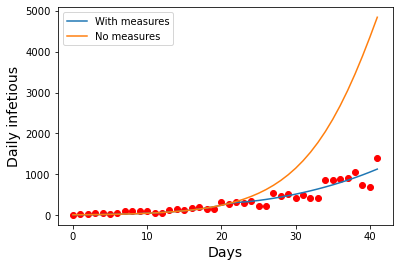

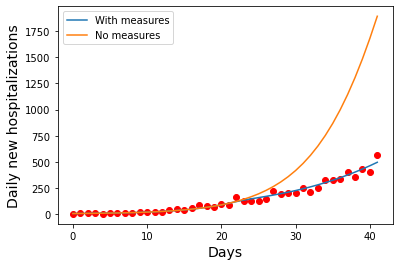

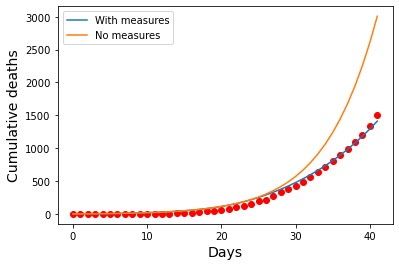

In [14]:
pl.figure()
pl.plot(Time2,data_infec,'ro')
pl.plot(Time2,incidence_cases_MAP, label = 'With measures')
pl.plot(Time2,incidence_cases_MAP_pred, label = 'No measures')
pl.xlabel("Days", fontsize=14)
pl.ylabel("Daily infetious", fontsize=14)
pl.legend(loc=0)
pl.savefig('results/data_inf_interventions.png')
pl.show()

pl.figure()
pl.plot(Time2,data_hosp,'ro')
pl.plot(Time2,hosp_cases_MAP, label = 'With measures')
pl.plot(Time2,hosp_cases_MAP_pred, label = 'No measures')
pl.xlabel("Days", fontsize=14)
pl.ylabel("Daily new hospitalizations", fontsize=14)
pl.legend(loc=0)
pl.savefig('results/data_hosp_interventions.png')
pl.show()

pl.figure()
pl.plot(Time2,data_cumu_death,'ro')
pl.plot(Time2,cumu_death_MAP, label = 'With measures')
pl.plot(Time2,cumu_death_MAP_pred, label = 'No measures')
pl.xlabel("Days", fontsize=14)
pl.ylabel("Cumulative deaths", fontsize=14)
pl.legend(loc=0)
pl.savefig('results/data_death_interventions.png')
pl.show()


In [15]:
E_0, I_0, beta_I1, eta, m, beta_I2, S_0 = MAP
print("beta_I1",beta_I1)
print("beta_I2",beta_I2)

eta_lower = np.quantile(chain[burnin:,3],0.05)
eta_higher = np.quantile(chain[burnin:,3],0.95)

m_lower = np.quantile(chain[burnin:,4],0.05)
m_higher = np.quantile(chain[burnin:,4],0.95)

beta_I2_lower = np.quantile(chain[burnin:,5],0.05)
beta_I2_higher = np.quantile(chain[burnin:,5],0.95)

beta_I1_lower = np.quantile(chain[burnin:,2],0.05)
beta_I1_higher = np.quantile(chain[burnin:,2],0.95)

N = S_0 + E_0 + A_0 + I_0 + H_0 + R_0 + D_0
q1_MAP_pred = np.array([beta_I1, eta, m, N])
q1_lower_pred = np.array([beta_I1_lower, eta, m, N])
q1_higher_pred = np.array([beta_I1_higher, eta, m, N])

q2_MAP_pred = np.array([beta_I2, eta, m, N])
q2_lower_pred = np.array([beta_I2_lower, eta, m_lower, N])
q2_higher_pred = np.array([beta_I2_higher, eta, m_higher, N])

x0 = np.array([S_0, E_0, A_0, I_0, H_0, R_0, D_0])

#### 20 days prediction: all following april data
N_days_new = N_days + 20

### MAP estimates
my_soln1_MAP_pred, my_soln2_MAP_pred = sol_betas_FT(x0,q1_MAP_pred,q2_MAP_pred,N_days_new)
exposed_day1_MAP_pred = my_soln1_MAP_pred[:,1]
exposed_day2_MAP_pred = my_soln2_MAP_pred[:,1][1:]
exposed_day_MAP_pred = np.concatenate((exposed_day1_MAP_pred, exposed_day2_MAP_pred))
infected_day1_MAP_pred = my_soln1_MAP_pred[:,3]
infected_day2_MAP_pred = my_soln2_MAP_pred[:,3][1:]
infected_day_MAP_pred = np.concatenate((infected_day1_MAP_pred, infected_day2_MAP_pred))
cumu_death1_MAP_pred = my_soln1_MAP_pred[:,6]
cumu_death2_MAP_pred = my_soln2_MAP_pred[:,6][1:]
cumu_death_MAP_pred = np.concatenate((cumu_death1_MAP_pred,cumu_death2_MAP_pred))
incidence_cases_MAP_pred = np.ones(len(exposed_day_MAP_pred))
incidence_cases_MAP_pred[0]=p*k*exposed_day_MAP_pred[0]
hosp_cases_MAP_pred = np.ones(len(infected_day_MAP_pred))
hosp_cases_MAP_pred[0]=eta*infected_day_MAP_pred[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_MAP_pred[i]=0.5*p*k*(exposed_day_MAP_pred[i]+exposed_day_MAP_pred[i-1])
    hosp_cases_MAP_pred[i]= 0.5*eta*(infected_day_MAP_pred[i]+infected_day_MAP_pred[i-1])

### MAP estimates no quarantine
my_soln1_MAP_pred_noq, my_soln2_MAP_pred_noq = sol_betas_FT(x0,q1_MAP_pred,q1_MAP_pred,N_days_new)
exposed_day1_MAP_pred_noq = my_soln1_MAP_pred_noq[:,1]
exposed_day2_MAP_pred_noq = my_soln2_MAP_pred_noq[:,1][1:]
exposed_day_MAP_pred_noq = np.concatenate((exposed_day1_MAP_pred_noq, exposed_day2_MAP_pred_noq))
infected_day1_MAP_pred_noq = my_soln1_MAP_pred_noq[:,3]
infected_day2_MAP_pred_noq = my_soln2_MAP_pred_noq[:,3][1:]
infected_day_MAP_pred_noq = np.concatenate((infected_day1_MAP_pred_noq, infected_day2_MAP_pred_noq))
cumu_death1_MAP_pred_noq = my_soln1_MAP_pred_noq[:,6]
cumu_death2_MAP_pred_noq = my_soln2_MAP_pred_noq[:,6][1:]
cumu_death_MAP_pred_noq = np.concatenate((cumu_death1_MAP_pred_noq,cumu_death2_MAP_pred_noq))
incidence_cases_MAP_pred_noq = np.ones(len(exposed_day_MAP_pred_noq))
incidence_cases_MAP_pred_noq[0]=p*k*exposed_day_MAP_pred_noq[0]
hosp_cases_MAP_pred_noq = np.ones(len(infected_day_MAP_pred_noq))
hosp_cases_MAP_pred_noq[0]=eta*infected_day_MAP_pred_noq[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_MAP_pred_noq[i]=0.5*p*k*(exposed_day_MAP_pred_noq[i]+exposed_day_MAP_pred_noq[i-1])
    hosp_cases_MAP_pred_noq[i]= 0.5*eta*(infected_day_MAP_pred_noq[i]+infected_day_MAP_pred_noq[i-1])

### MAP estimates no quarantine lower beta_I1
my_soln1_lower_pred_noq, my_soln2_lower_pred_noq = sol_betas_FT(x0,q1_lower_pred,q1_lower_pred,N_days_new)
exposed_day1_lower_pred_noq = my_soln1_lower_pred_noq[:,1]
exposed_day2_lower_pred_noq = my_soln2_lower_pred_noq[:,1][1:]
exposed_day_lower_pred_noq = np.concatenate((exposed_day1_lower_pred_noq, exposed_day2_lower_pred_noq))
infected_day1_lower_pred_noq = my_soln1_lower_pred_noq[:,3]
infected_day2_lower_pred_noq = my_soln2_lower_pred_noq[:,3][1:]
infected_day_lower_pred_noq = np.concatenate((infected_day1_lower_pred_noq, infected_day2_lower_pred_noq))
cumu_death1_lower_pred_noq = my_soln1_lower_pred_noq[:,6]
cumu_death2_lower_pred_noq = my_soln2_lower_pred_noq[:,6][1:]
cumu_death_lower_pred_noq = np.concatenate((cumu_death1_lower_pred_noq,cumu_death2_lower_pred_noq))
incidence_cases_lower_pred_noq = np.ones(len(exposed_day_lower_pred_noq))
incidence_cases_lower_pred_noq[0]=p*k*exposed_day_lower_pred_noq[0]
hosp_cases_lower_pred_noq = np.ones(len(infected_day_lower_pred_noq))
hosp_cases_lower_pred_noq[0]=eta*infected_day_lower_pred_noq[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_lower_pred_noq[i]=0.5*p*k*(exposed_day_lower_pred_noq[i]+exposed_day_lower_pred_noq[i-1])
    hosp_cases_lower_pred_noq[i]= 0.5*eta*(infected_day_lower_pred_noq[i]+infected_day_lower_pred_noq[i-1])

### MAP estimates no quarantine higher beta_I1
my_soln1_higher_pred_noq, my_soln2_higher_pred_noq = sol_betas_FT(x0,q1_higher_pred,q1_higher_pred,N_days_new)
exposed_day1_higher_pred_noq = my_soln1_higher_pred_noq[:,1]
exposed_day2_higher_pred_noq = my_soln2_higher_pred_noq[:,1][1:]
exposed_day_higher_pred_noq = np.concatenate((exposed_day1_higher_pred_noq, exposed_day2_higher_pred_noq))
infected_day1_higher_pred_noq = my_soln1_higher_pred_noq[:,3]
infected_day2_higher_pred_noq = my_soln2_higher_pred_noq[:,3][1:]
infected_day_higher_pred_noq = np.concatenate((infected_day1_higher_pred_noq, infected_day2_higher_pred_noq))
cumu_death1_higher_pred_noq = my_soln1_higher_pred_noq[:,6]
cumu_death2_higher_pred_noq = my_soln2_higher_pred_noq[:,6][1:]
cumu_death_higher_pred_noq = np.concatenate((cumu_death1_higher_pred_noq,cumu_death2_higher_pred_noq))
incidence_cases_higher_pred_noq = np.ones(len(exposed_day_higher_pred_noq))
incidence_cases_higher_pred_noq[0]=p*k*exposed_day_higher_pred_noq[0]
hosp_cases_higher_pred_noq = np.ones(len(infected_day_higher_pred_noq))
hosp_cases_higher_pred_noq[0]=eta*infected_day_higher_pred_noq[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_higher_pred_noq[i]=0.5*p*k*(exposed_day_higher_pred_noq[i]+exposed_day_higher_pred_noq[i-1])
    hosp_cases_higher_pred_noq[i]= 0.5*eta*(infected_day_higher_pred_noq[i]+infected_day_higher_pred_noq[i-1])


### MAP estimates lower in beta_I2
my_soln1_lower_pred, my_soln2_lower_pred = sol_betas_FT(x0,q1_MAP_pred,q2_lower_pred,N_days_new)
exposed_day1_lower_pred = my_soln1_lower_pred[:,1]
exposed_day2_lower_pred = my_soln2_lower_pred[:,1][1:]
exposed_day_lower_pred = np.concatenate((exposed_day1_lower_pred, exposed_day2_lower_pred))
infected_day1_lower_pred = my_soln1_lower_pred[:,3]
infected_day2_lower_pred = my_soln2_lower_pred[:,3][1:]
infected_day_lower_pred = np.concatenate((infected_day1_lower_pred, infected_day2_lower_pred))
cumu_death1_lower_pred = my_soln1_lower_pred[:,6]
cumu_death2_lower_pred = my_soln2_lower_pred[:,6][1:]
cumu_death_lower_pred = np.concatenate((cumu_death1_lower_pred,cumu_death2_lower_pred))
incidence_cases_lower_pred = np.ones(len(exposed_day_lower_pred))
incidence_cases_lower_pred[0]=p*k*exposed_day_lower_pred[0]
hosp_cases_lower_pred = np.ones(len(infected_day_lower_pred))
hosp_cases_lower_pred[0]=eta*infected_day_lower_pred[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_lower_pred[i]=0.5*p*k*(exposed_day_lower_pred[i]+exposed_day_lower_pred[i-1])
    hosp_cases_lower_pred[i]= 0.5*eta*(infected_day_lower_pred[i]+infected_day_lower_pred[i-1])

### MAP estimates higher in beta_I2
my_soln1_higher_pred, my_soln2_higher_pred = sol_betas_FT(x0,q1_MAP_pred,q2_higher_pred,N_days_new)
exposed_day1_higher_pred = my_soln1_higher_pred[:,1]
exposed_day2_higher_pred = my_soln2_higher_pred[:,1][1:]
exposed_day_higher_pred = np.concatenate((exposed_day1_higher_pred, exposed_day2_higher_pred))
infected_day1_higher_pred = my_soln1_higher_pred[:,3]
infected_day2_higher_pred = my_soln2_higher_pred[:,3][1:]
infected_day_higher_pred = np.concatenate((infected_day1_higher_pred, infected_day2_higher_pred))
cumu_death1_higher_pred = my_soln1_higher_pred[:,6]
cumu_death2_higher_pred = my_soln2_higher_pred[:,6][1:]
cumu_death_higher_pred = np.concatenate((cumu_death1_higher_pred,cumu_death2_higher_pred))
incidence_cases_higher_pred = np.ones(len(exposed_day_higher_pred))
incidence_cases_higher_pred[0]=p*k*exposed_day_higher_pred[0]
hosp_cases_higher_pred = np.ones(len(infected_day_higher_pred))
hosp_cases_higher_pred[0]=eta*infected_day_higher_pred[0]
for i in np.arange(1,N_days_new,1):
    incidence_cases_higher_pred[i]=0.5*p*k*(exposed_day_higher_pred[i]+exposed_day_higher_pred[i-1])
    hosp_cases_higher_pred[i]= 0.5*eta*(infected_day_higher_pred[i]+infected_day_higher_pred[i-1])


beta_I1 0.4147757511173412
beta_I2 0.24380810535195332


In [16]:
Time3 = np.arange(0,N_days_new,1)

#############################################################################
from datetime import datetime, date, time, timedelta
format = "%b %d"

d1 = date(2020, 3, 10)
d2 = d1 + timedelta(days=10)
d3 = d1 + timedelta(days=10*2)
d4 = d1 + timedelta(days=10*3)
d5 = d1 + timedelta(days=10*4)
d6 = d1 + timedelta(days=10*5)
d7 = d1 + timedelta(days=10*6)
dd1 = d1.strftime(format)
dd2 = d2.strftime(format)
dd3 = d3.strftime(format)
dd4 = d4.strftime(format)
dd5 = d5.strftime(format)
dd6 = d6.strftime(format)
dd7 = d7.strftime(format)


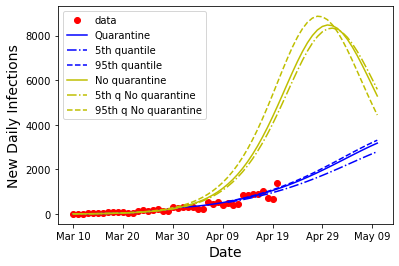

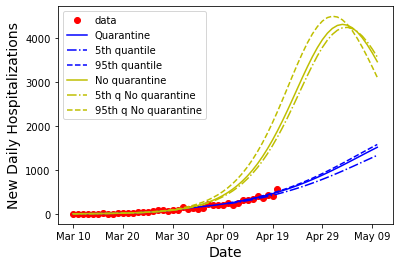

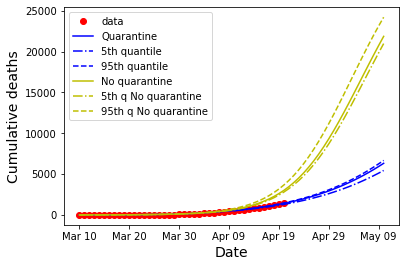

In [18]:
pl.figure()
pl.plot(Time2,data_infec,'ro', label = 'data')
pl.plot(Time3,incidence_cases_MAP_pred,'b-' , label = 'Quarantine')
pl.plot(Time3[31:],incidence_cases_lower_pred[31:], 'b-.', label = '5th quantile')
pl.plot(Time3[31:],incidence_cases_higher_pred[31:], 'b--' , label = '95th quantile')
pl.plot(Time3,incidence_cases_MAP_pred_noq, 'y-', label = 'No quarantine')
pl.plot(Time3,incidence_cases_lower_pred_noq, 'y-.', label = '5th q No quarantine')
pl.plot(Time3,incidence_cases_higher_pred_noq, 'y--', label = '95th q No quarantine')
pl.xlabel("Date", fontsize=14)
pl.ylabel("New Daily Infections", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_inf_pred.png')
pl.show()

pl.figure()
pl.plot(Time2,data_hosp,'ro', label = 'data')
pl.plot(Time3,hosp_cases_MAP_pred, 'b-', label = 'Quarantine')
pl.plot(Time3[31:],hosp_cases_lower_pred[31:], 'b-.', label = '5th quantile')
pl.plot(Time3[31:],hosp_cases_higher_pred[31:], 'b--' , label = '95th quantile')
pl.plot(Time3,hosp_cases_MAP_pred_noq,'y-', label = 'No quarantine')
pl.plot(Time3,hosp_cases_lower_pred_noq, 'y-.',label = '5th q No quarantine')
pl.plot(Time3,hosp_cases_higher_pred_noq, 'y--',label = '95th q No quarantine')
pl.xlabel("Date", fontsize=14)
pl.ylabel("New Daily Hospitalizations", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_hosp_pred.png')
pl.show()


pl.figure()
pl.plot(Time2,data_cumu_death,'ro', label = 'data')
pl.plot(Time3,cumu_death_MAP_pred,'b-', label = 'Quarantine')
pl.plot(Time3[31:],cumu_death_lower_pred[31:], 'b-.', label = '5th quantile')
pl.plot(Time3[31:],cumu_death_higher_pred[31:], 'b--' , label = '95th quantile')
pl.plot(Time3,cumu_death_MAP_pred_noq, 'y-',label = 'No quarantine')
pl.plot(Time3,cumu_death_lower_pred_noq, 'y-.',label = '5th q No quarantine')
pl.plot(Time3,cumu_death_higher_pred_noq, 'y--',label = '95th q No quarantine')
pl.xlabel("Date", fontsize=14)
pl.ylabel("Cumulative deaths", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_death_pred.png')
pl.show()


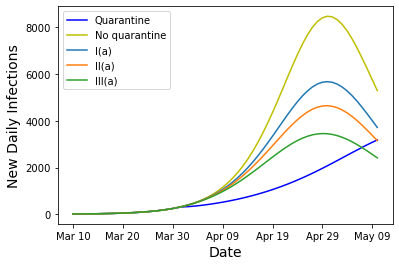

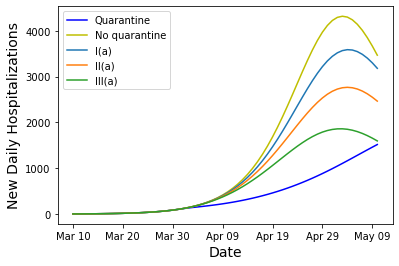

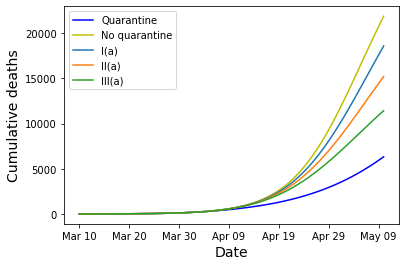

In [19]:
### Set the dynamical system for vaccination
def rhs_vac(x,t,q):
    beta_I, eta, m, N = q1_MAP_pred
    phi, psi, p_tilde = q
    m_I = 0.1*m
    beta_A = 2.0 * beta_I

    fx = np.zeros(9)
    fx[0] = -(beta_A*x[2]+beta_I*x[3])*x[0]/N - phi*x[0]   ### S dot
    fx[1] = (beta_A*x[2]+beta_I*x[3])*x[0]/N - k*x[1]  ### E dot
    fx[2] = (1-p)*k*x[1] -gamma_A*x[2] + (1-p_tilde)*k*x[8] ### A dot
    fx[3] = p*k*x[1] + p_tilde*k*x[8] - gamma*x[3] - eta*x[3] -m_I*x[3] ### I dot
    fx[4] = eta*x[3] - gamma_H*x[4] - m*x[4] ### H dot
    fx[5] = gamma_A * x[2] + gamma*x[3] + gamma_H*x[4] ### R dot
    fx[6] = m*x[4] + m_I*x[3]   ### D dot
    fx[7] = -(1.0-psi)*(beta_A*x[2]+beta_I*x[3])/N*x[7] + phi*x[0] ### V dot
    fx[8] = (1.0-psi)*(beta_A*x[2]+beta_I*x[3])/N*x[7] - k*x[8] ### Etilde dot
    return fx

def soln_vac(x0,Time,q):
        return integrate.odeint(rhs_vac,x0,Time,args=(q,))

x0_noq_vac = np.concatenate((my_soln1_MAP_pred_noq[-1], np.array([0, 0])))


# I(a)
C1       = 0.30 # coverage
psi1     = 0.50 # effectivity
p_tilde1 = 0.50 # symptomatic fraction
tau1     = 30 #coverage time
phi1     = np.log(1-C1)/(-tau1)
q_vac_I_a = np.array([phi1, psi1, p_tilde1])

# II(a)
C1       = 0.40 # coverage
psi1     = 0.65 # effectivity
p_tilde1 = 0.30 # symptomatic fraction
tau1     = 30 #coverage time
phi1     = np.log(1-C1)/(-tau1)
q_vac_II_a = np.array([phi1, psi1, p_tilde1])

# III(a)
C1       = 0.50 # coverage
psi1     = 0.80 # effectivity
p_tilde1 = 0.10 # symptomatic fraction
tau1     = 30 #coverage time
phi1     = np.log(1-C1)/(-tau1)
q_vac_III_a = np.array([phi1, psi1, p_tilde1])

Time03 = np.arange(N_days1-1,N_days_new,1)
my_soln1_MAP_pred_noq = np.delete(my_soln1_MAP_pred_noq, -1, axis=0)

def get_noq_vaccinated(q_vac):
    my_sol_vac = soln_vac(x0_noq_vac, Time03, q_vac)
    My_soln = np.concatenate((my_soln1_MAP_pred_noq, my_sol_vac[:,0:7]))
    exposed_new = My_soln[:,1]
    infected_new = My_soln[:,3]
    cumu_death = My_soln[:,6]
    incidence_new = np.ones(len(exposed_new))
    incidence_new[0]=p*k*exposed_new[0]
    hosp_cases = np.ones(len(infected_new))
    hosp_cases[0]=eta*infected_new[0]

    for i in np.arange(1,len(Time3),1):
        incidence_new[i]=0.5*p*k*(exposed_new[i]+exposed_new[i-1])
        hosp_cases[i]= 0.5*eta*(infected_new[i]+infected_new[i-1])
    return incidence_new, hosp_cases, cumu_death

vac_noq_I, H_noq_vac_I, D_noq_vac_I  = get_noq_vaccinated(q_vac_I_a)
vac_noq_II, H_noq_vac_II, D_noq_vac_II = get_noq_vaccinated(q_vac_II_a)
vac_noq_III, H_noq_vac_III, D_noq_vac_III = get_noq_vaccinated(q_vac_III_a)

pl.figure()
pl.plot(Time3,incidence_cases_MAP_pred,'b-' , label = 'Quarantine')
pl.plot(Time3,incidence_cases_MAP_pred_noq, 'y-', label = 'No quarantine')
pl.plot(Time3,vac_noq_I, label='I(a)')
pl.plot(Time3,vac_noq_II, label='II(a)')
pl.plot(Time3,vac_noq_III, label='III(a)')
pl.xlabel("Date", fontsize=14)
pl.ylabel("New Daily Infections", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_inf_control.png')
pl.show()

pl.figure()
pl.plot(Time3,hosp_cases_MAP_pred, 'b-', label = 'Quarantine')
pl.plot(Time3,hosp_cases_MAP_pred_noq,'y-', label = 'No quarantine')
pl.plot(Time3,H_noq_vac_I, label='I(a)')
pl.plot(Time3,H_noq_vac_II, label='II(a)')
pl.plot(Time3,H_noq_vac_III, label='III(a)')
pl.xlabel("Date", fontsize=14)
pl.ylabel("New Daily Hospitalizations", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_hosp_control.png')
pl.show()



pl.figure()
pl.plot(Time3,cumu_death_MAP_pred,'b-', label = 'Quarantine')
pl.plot(Time3,cumu_death_MAP_pred_noq, 'y-',label = 'No quarantine')
pl.plot(Time3,D_noq_vac_I, label='I(a)')
pl.plot(Time3,D_noq_vac_II, label='II(a)')
pl.plot(Time3,D_noq_vac_III, label='III(a)')
pl.xlabel("Date", fontsize=14)
pl.ylabel("Cumulative deaths", fontsize=14)
pl.xticks([0, 10, 10*2, 10*3, 10*4, 10*5, 10*6],labels=[dd1,dd2,dd3,dd4,dd5,dd6,dd7])
pl.legend(loc=0)
pl.savefig('results/data_death_control.png')
pl.show()
